# Configure Settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import ast
import os

from utils import *

# configure display options
pd.options.display.max_rows = 500  # can set to `None`
pd.options.display.max_columns = 500  # can set to `None`
pd.options.display.max_colwidth = 30
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=3, suppress=True)
# warnings.filterwarnings('ignore')

# track runtime
# t0 = perf_counter()

In [2]:
%%html
<style>
.dataframe td {
    white-space: nowrap;
}
</style>

# Load Data

In [3]:
for dirname, _, filenames in os.walk('source/orig'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

source/orig\yelp_academic_dataset_business.json
source/orig\yelp_academic_dataset_user.json
source/orig\yelp_academic_dataset_review.json


In [4]:
path, filename, filetype = 'source/orig/', 'yelp_academic_dataset_business', 'json'
df_b = load_print_data(path, filename, filetype)
df_b.head()

  File: yelp_academic_dataset_business
Memory: 195,875,702 bytes
 Shape: (160585, 14)

Finished 'load_print_data' in 3.705 secs



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.02,-105.28,4.00,86,1,{'RestaurantsTableService'...,"Gastropubs, Food, Beer Gar...","{'Monday': '11:0-23:0', 'T..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.59,-122.59,4.00,126,1,{'RestaurantsTakeOut': 'Tr...,"Salad, Soup, Sandwiches, D...","{'Monday': '5:0-18:0', 'Tu..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.51,-122.61,4.50,13,1,{'BusinessAcceptsCreditCar...,"Antiques, Fashion, Used, V...","{'Thursday': '11:0-18:0', ..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.91,-81.30,3.00,8,1,{'RestaurantsPriceRange2':...,"Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.75,-84.35,4.00,14,1,"{'GoodForKids': 'False', '...","Gyms, Active Life, Interva...","{'Monday': '16:0-19:0', 'T..."


In [5]:
# filter only open business
df_b = df_b[df_b['is_open']==1]

# filter entries containing restaurant or food under categories
condition = df_b['categories'].str.contains('restaurant|food', regex=True, flags=re.I)
df_b = df_b[condition==True].reset_index(drop=True)

In [6]:
df_b.shape

(41768, 14)

# Make Nested Columns Usable

## Examine Nested Columns and Value Gained per Extraction

In [7]:
def plot_freq(df_from, col, bins=None, nested=False):
    df_from = df_from.copy()
    df_from[col] = df_from[col].str.len().fillna(0) if nested else df_from[col]
    _, (ax1, ax2) = plt.subplots(2, figsize=(8,4), sharex=True)
    bins = int(max(df_from[col])) if bins==None else bins
    count, bin_count = np.histogram(df_from[col], bins=bins)
    pmf = count/sum(count)
    cdf = np.cumsum(pmf)
    ax1.plot(bin_count[1:], cdf, label='CDF')
    ax2.plot(bin_count[1:], pmf, label='PMF')
    ax2.set_xlabel(f'Count of {col.title()}')
    ax1.set_ylabel('Probability')
    ax2.set_ylabel('Probability')
    ax1.set_title(f'CDF and PMF for Count of {col.title()}')
    ax1.legend()
    ax2.legend()
    plt.show()

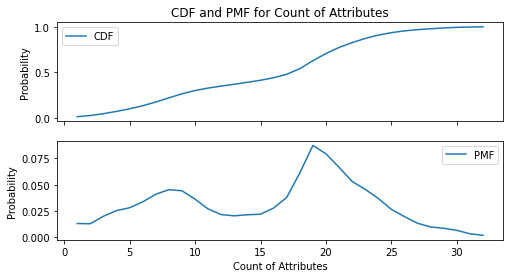

In [8]:
plot_freq(df_b, 'attributes', nested=True)

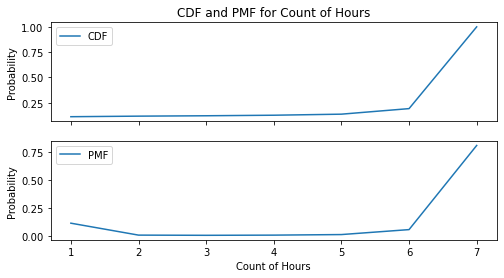

In [9]:
plot_freq(df_b, 'hours', nested=True)

## Extract Business Hours

In [10]:
# parse business hours column
df_hrs_norm = pd.json_normalize(df_b['hours'])

# make a new column
df_b['days_open'] = df_hrs_norm.notnull().sum(axis=1)

# extract open and close hours for each day the business is open
df_hrs = pd.DataFrame()
for day in df_hrs_norm.columns:
    df_day_time = df_hrs_norm[day].str.split('-', expand=True).rename({0:f'{day}_start', 1:f'{day}_end'}, axis=1)
    for col in df_day_time.columns:
        df_day_time[col] = pd.to_datetime(df_day_time[col], format='%H:%M')
    df_hrs = pd.concat([df_hrs, df_day_time], axis=1)

In [11]:
# extract duration business hours for each day the business is open
for i in range(1, 14, 2):
    df_hrs[df_hrs.iloc[:, i].name.split('_')[0] + '_dur'] = df_hrs.iloc[:, i] - df_hrs.iloc[:, i-1]

## Fix Negative Business Hours

In [23]:
# examine negative duration to fix errors in data
neg_dur = df_hrs[[i for i in df_hrs.columns if 'dur' in i]]<pd.Timedelta(0)
# across cols if any are True filter only that data
neg_dur = neg_dur.query(' or '.join([i for i in df_hrs.columns if 'dur' in i])) 
df_neg_dur = df_hrs[df_hrs.index.isin(neg_dur.index)]
print(df_neg_dur.shape)
df_neg_dur.head()

(881, 21)


,Monday_start,Monday_end,Tuesday_start,Tuesday_end,Wednesday_start,Wednesday_end,Thursday_start,Thursday_end,Friday_start,Friday_end,Saturday_start,Saturday_end,Sunday_start,Sunday_end,Monday_dur,Tuesday_dur,Wednesday_dur,Thursday_dur,Friday_dur,Saturday_dur,Sunday_dur
184,1900-01-01 16:00:00,1900-01-01 23:00:00,1900-01-01 16:00:00,1900-01-01 23:00:00,1900-01-01 16:00:00,1900-01-01 23:00:00,1900-01-01 16:00:00,1900-01-01 23:00:00,1900-01-01 16:00:00,1900-01-01 12:30:00,1900-01-01 16:00:00,1900-01-01 12:30:00,1900-01-01 16:00:00,1900-01-01 23:00:00,0 days 07:00:00,0 days 07:00:00,0 days 07:00:00,0 days 07:00:00,-1 days +20:30:00,-1 days +20:30:00,0 days 07:00:00
213,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 19:00:00,1900-01-01 14:00:00,1900-01-01 19:00:00,1900-01-01 14:00:00,NaT,NaT,NaT,NaT,NaT,NaT,-1 days +19:00:00,-1 days +19:00:00,NaT
328,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1900-01-01 18:00:00,1900-01-01 13:00:00,1900-01-01 18:00:00,1900-01-01 13:00:00,1900-01-01 18:00:00,1900-01-01 13:00:00,NaT,NaT,NaT,NaT,-1 days +19:00:00,-1 days +19:00:00,-1 days +19:00:00
382,1900-01-01 16:00:00,1900-01-01 14:00:00,1900-01-01 16:00:00,1900-01-01 14:00:00,1900-01-01 16:00:00,1900-01-01 14:00:00,1900-01-01 16:00:00,1900-01-01 14:00:00,1900-01-01 16:00:00,1900-01-01 14:00:00,1900-01-01 14:00:00,1900-01-01 14:00:00,1900-01-01 14:00:00,1900-01-02 00:00:00,-1 days +22:00:00,-1 days +22:00:00,-1 days +22:00:00,-1 days +22:00:00,-1 days +22:00:00,0 days 00:00:00,0 days 10:00:00
421,1900-01-01 11:00:00,1900-01-01 13:00:00,1900-01-01 11:00:00,1900-01-01 13:00:00,1900-01-01 11:00:00,1900-01-01 13:00:00,1900-01-01 17:00:00,1900-01-01 13:00:00,1900-01-01 11:00:00,1900-01-01 13:00:00,1900-01-01 11:00:00,1900-01-01 13:00:00,1900-01-01 12:00:00,1900-01-01 13:00:00,0 days 02:00:00,0 days 02:00:00,0 days 02:00:00,-1 days +20:00:00,0 days 02:00:00,0 days 02:00:00,0 days 01:00:00


In [29]:
# clean up hours to adjust for negative durations
for prefix in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']:
    r = (df_hrs[prefix + '_dur']<pd.Timedelta(0)) 
    df_hrs[prefix + '_end'] = np.where(r & (df_hrs[prefix + '_end']==pd.Timestamp('1900-01-01 00:00:00')), 
        df_hrs[prefix + '_end'] + pd.Timedelta(days=1),
            np.where(r & (df_hrs[prefix + '_end']!=pd.Timestamp('1900-01-01 00:00:00')), 
                df_hrs[prefix + '_end'] + pd.Timedelta(hours=12), df_hrs[prefix + '_end']))

In [30]:
# extract duration for each day
for i in range(1, 14, 2):
    df_hrs[df_hrs.iloc[:, i].name.split('_')[0] + '_dur'] = df_hrs.iloc[:, i] - df_hrs.iloc[:, i-1]

In [32]:
neg_dur = df_hrs[[i for i in df_hrs.columns if 'dur' in i]]<pd.Timedelta(0)
neg_dur = neg_dur.query(' or '.join([i for i in df_hrs.columns if 'dur' in i]))
df_neg_dur = df_hrs[df_hrs.index.isin(neg_dur.index)]
print(df_neg_dur.shape)

(0, 21)


## Make More Columns with Business Hours

In [33]:
# calculate business hours per week
df_hrs['hrs_per_wk'] = df_hrs[[i for i in df_hrs.columns if '_dur' in i]].sum(axis=1)
df_hrs['wknd_hrs'] = df_hrs[[i for i in df_hrs.columns if '_dur' in i][-3:]].sum(axis=1)
df_hrs['wknd_hrs_perc'] = df_hrs['wknd_hrs']/df_hrs['hrs_per_wk']

In [45]:
def inspect_null_info(df_from):
    null_ct = df_from.isnull().sum()
    tot_ct = df_from.shape[0]
    print(f'Total Null %: {null_ct/tot_ct*100:,.0f}%', end=' --- ')
    print(f'Total Null Ct: {null_ct:,}', end=' --- ')
    print(f'Total Data Ct: {tot_ct:,}')

In [46]:
inspect_null_info(df_hrs['wknd_hrs_perc'])

Total Null %: 15% --- Total Null Ct: 6,098 --- Total Data Ct: 41,768


In [47]:
df_hrs['wknd_hrs_perc'].describe()

count   35,670.00
mean         0.44
std          0.11
min          0.00
25%          0.41
50%          0.43
75%          0.49
max          1.00
Name: wknd_hrs_perc, dtype: float64

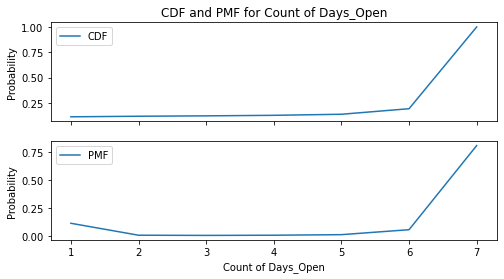

In [48]:
plot_freq(df_b.loc[df_b['days_open'].dropna().index.values], 'days_open')

# Other Columns to Unnest

In [49]:
def unnest_col(df_from, col_lvl1, col_lvl2, col_prefix):
    df_out = pd.DataFrame()
    for i in range(len(df_from)):
        try:
            df_to_add = pd.json_normalize(ast.literal_eval(
                pd.json_normalize(df_from.loc[i, col_lvl1])[col_lvl2].squeeze())) # .astype(int)
            df_to_add.index = [i]
        except (KeyError, NotImplementedError):
            df_to_add = pd.DataFrame({'noval': np.nan}, index=[i])
        df_out = pd.concat([df_out, df_to_add], axis=0)
    df_out.drop(['noval'], axis=1, inplace=True)
    df_out.columns = [f'{col_prefix}_' + i for i in df_out.columns]
    return df_out

In [50]:
# df1 = unnest_col(df_b, 'attributes', 'BestNights', 'bn')
df2 = unnest_col(df_b, 'attributes', 'BusinessParking', 'bp')
df3 = unnest_col(df_b, 'attributes', 'Ambience', 'amb')
df4 = unnest_col(df_b, 'attributes', 'GoodForMeal', 'gfm')
hrs = pd.json_normalize(df_b['hours'])

In [51]:
null_collection = list()
for df in [df1, df2, df3, df4, df5, df6]:
    null_collection.append(inspect_null_info(df))

NameError: name 'df1' is not defined

In [ ]:
for i in range(6):
    print(null_collection[i])

In [ ]:
col_dict = {
    'BusinessParking': 'bp',
    'Ambience': 'amb',
    'GoodForMeal': 'gfm',
    'hours': 'hrs',
    'music': 'music',     
    'best_nights': 'best_nights'
}

# Manual

In [ ]:
# # change json to df and attach an id
# df_to_add = df_b['attributes'][0]
# df_to_add['business_id'] = df_b['business_id'][0]
# df_to_add = pd.DataFrame.from_records(df_to_add, index=[0])
# # parse string dictionaries
# df_to_add['Ambience'] = parse_str_dict(df_to_add, 'Ambience')
# df_to_add['BusinessParking'] = parse_str_dict(df_to_add, 'BusinessParking')
# df_to_add['GoodForMeal'] = parse_str_dict(df_to_add, 'GoodForMeal')
# # change value format
# for col in ['WiFi', 'Alcohol', 'NoiseLevel', 'RestaurantsAttire']:
#     df_to_add[col] = ast.literal_eval(df_to_add[col][0])

# Load Other Datasets

In [ ]:
df_r = []
r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32,
           }
with open("source/yelp_academic_dataset_review.json", "r", encoding='utf-8') as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=10000)
        
    for chunk in reader:
        bid = df_b['business_id'].values
        reduced_chunk = chunk.query("(`date` >= '2018-12-01') & (business_id in @bid)")
        df_r.append(reduced_chunk)
    
df_r = pd.concat(df_r, ignore_index=True)

In [ ]:
df_r.shape

In [ ]:
df_r.head()

In [ ]:
df_r['date'].describe(datetime_is_numeric=True)

In [ ]:
df_u = []
r_dtypes = {'user_id':str,'name':str,
    'review_count':int,'yelping_since':str,
    'useful':int,'funny':int,'cool':int,'fans':int, 'average_stars':float}
with open("source/yelp_academic_dataset_user.json", "r", encoding='utf-8') as f:
    reader = pd.read_json(f, orient="records", lines=True, 
                          dtype=r_dtypes, chunksize=10000)
        
    for chunk in reader:
        uid = set(df_r['user_id'])
        reduced_chunk = chunk.query("(user_id in @uid)")
        df_u.append(reduced_chunk)
    
df_u = pd.concat(df_u, ignore_index=True)

In [ ]:
df_u.shape

In [ ]:
df_u.head()

# Save Data

In [ ]:
ref = dict(zip(['business', 'reviews', 'users'], [df_b, df_r, df_u]))
for name, df in ref.items():
    df.to_parquet(f'source/yelp_restaurants_{name}.parquet')